$$
\Huge \blue{\textbf{Simple Covariate Shift \qquad}} \\
$$

## Imports & Settings

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import roc_curve #, classification_report, roc_auc_score, accuracy_score, f1_score, 
    
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from pygam import s, te, f, LogisticGAM
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ortho_group

import xgboost as xgb

from src.data_generation import *
from src.analysis import ModelEvaluator
from src.utils import *
from src.plotting import visualize_feature_shifts
from src.grid_search import *

np.random.seed(0)

GRID_SEARCH = False
PLOT = False
GEN_DATA = True
OVERFIT = False

# 1. Data Creation

In [2]:
DATA_FOLDER = 'data'

# Parameter definition

num_samples = 10000
num_features = 3

# degree of the polinomio for the attribute relationship
degree = 2

## Training Set

In [3]:
if GEN_DATA:
    # random multivariate

    mean_train = [0.90920214, 0.81962487, 0.88819135]

    covariance_train = np.array([[0.726318, 0.20240102, 0.52472545],
                                [0.20240102, 0.11392557, 0.0264108],
                                [0.52472545, 0.0264108, 1.05107627]])

    # build the features sample
    sample_train = build_multivariate_sample(num_samples, mean_train, covariance_train)
    sample_train

In [4]:

if GEN_DATA:
    df_train = pd.DataFrame(sample_train, columns=[f'X{i+1}' for i in range(num_features)])

    # build target variable y
    # random coefficients (otherwise remove coef from build_poly_target and will be randomly generated)
    coef = [-0.8061577012389105, -0.3621987584904036, -0.16057091147074054, 0.4803476403769713, -0.10624889645240687, 
            0.3182084398201366, 0.6789895126695962, -0.791324832566177, 0.531479159887424, 0.49115959567000167]

    y_train, z_train, coef_train = build_poly_target(sample_train, degree, coef)
    df_train['Y'] = y_train
    df_train['Z'] = z_train

    # check for balance
    df_train['Y'].value_counts()

    ir = max(df_train['Y'].value_counts()) / min(df_train['Y'].value_counts())
    ir

In [5]:
if GEN_DATA:
    df_train = pd.DataFrame(sample_train, columns=[f'X{i+1}' for i in range(num_features)])

    # build target variable y
    # random coefficients (otherwise remove coef from build_poly_target and will be randomly generated)
    coef = [-0.8061577012389105, -0.3621987584904036, -0.16057091147074054, 0.4803476403769713, -0.10624889645240687, 
            0.3182084398201366, 0.6789895126695962, -0.791324832566177, 0.531479159887424, 0.49115959567000167]

    y_train, z_train, coef_train = build_poly_target(sample_train, degree, coef)
    df_train['Y'] = y_train
    df_train['Z'] = z_train

    y_train, z_train, coef_train = build_poly_target(sample_train, degree, coef)
    df_train['Y'] = y_train
    df_train['Z'] = z_train

    # check for balance
    df_train['Y'].value_counts()
    ir = max(df_train['Y'].value_counts()) / min(df_train['Y'].value_counts())
    ir

In [6]:
df_train.head() if GEN_DATA else None

,X1,X2,X3,Y,Z
0,-0.613910,0.636546,-0.615946,0,-1.232201
1,-1.475274,-0.125569,-0.585207,0,0.075931
2,0.294592,0.722642,-0.078352,1,-1.463998
3,0.448019,0.953445,0.595365,0,-0.783403
4,0.273194,0.757800,0.220965,0,-1.163165


## Testing Sets: Shifted Distribution Mixtures

To be as general as possible, we consider statistical mixtures and study the presumed progressive degradation in performance for increasingly pure mixtures towards the test distribution.

In [7]:
if GEN_DATA:
    # shifted random multivariate
    mean_shift = attributes_quantile(df_train, 0.05)

    covariance_shift = [[ 0.16309729,  0.19325742, -0.12621892],
                        [ 0.19325742,  0.25197638, -0.13972381],
                        [-0.12621892, -0.13972381,  0.19160666]]

    # Initialize an empty dictionary to store the dataframes
    df_dict = {}

    # Iterate over mix_prob values
    for mix_prob in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        # Generate mixture sample
        sample_mix = build_mixture_sample(num_samples, mean_train, covariance_train, mean_shift, covariance_shift, mix_prob=mix_prob)

        # Create a DataFrame for the features
        df_mix = pd.DataFrame(sample_mix, columns=[f'X{i+1}' for i in range(num_features)])

        # Build the target variable y
        y_mix, z_mix, coef_mix = build_poly_target(sample_mix, degree, coefficients=coef_train)
        df_mix['Y'] = y_mix
        df_mix['Z'] = z_mix

        # Store the DataFrame in the dictionary
        df_dict[mix_prob] = df_mix


In [8]:
ir = {}

for mprob in df_dict.keys():
    ir[mprob] = max(df_dict[mprob]['Y'].value_counts()) / min(df_dict[mprob]['Y'].value_counts())

ir

{0.0: 1.2187708009762592,
 0.1: 1.1222410865874364,
 0.2: 1.0,
 0.3: 1.0622808826562178,
 0.4: 1.2291573785109229,
 0.5: 1.376425855513308,
 0.6: 1.4612355402412012,
 0.7: 1.6048450117218025,
 0.8: 1.7917364600781687,
 0.9: 2.056234718826406,
 1.0: 2.2637075718015667}

Remark: the 0.0 is a sample from the distribution that generated the training set. Since `build_mixture_sample` function do the sample each time, the 0.0 sample can be used as test set.

## Saving Data to Files

In [9]:
if GEN_DATA:
    # Create a folder
    os.makedirs(DATA_FOLDER, exist_ok=True)

    for mix_prob, df in df_dict.items():
        df.to_csv(os.path.join(DATA_FOLDER, f'mix_{mix_prob}.csv'), index=False)
    file_name = 'Parameters.txt'
    file_path = os.path.join(DATA_FOLDER, file_name)
    df_train.to_csv(os.path.join(DATA_FOLDER, 'train.csv'), index=False)

    with open(file_path, 'w') as f:
        f.write('Polinomial coefficients\n')
        f.write(f'{coef_train}\n')
        f.write('Mean train\n')
        f.write(f'{mean_train}\n')
        f.write('Covariance train\n')
        f.write(f'{covariance_train}\n')
        f.write('Mean shift\n')
        f.write(f'{mean_shift}\n')
        f.write('Covariance shift\n')
        f.write(f'{covariance_shift}\n')

## Read data from files

In [10]:
if not GEN_DATA:
    # Read data
    df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
    X_train = df_train.drop(columns=['Y', 'Z'])
    y_train = df_train['Y']
    z_train = df_train['Z']
    df_dict = {}
    for mix_prob in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        df_dict[mix_prob] = pd.read_csv(os.path.join(DATA_FOLDER, f'mix_{mix_prob}.csv'))
    
    with open(os.path.join(DATA_FOLDER, "Parameters.txt"), 'r') as f:
        lines = f.readlines()
        # Line with coefficients (second line)
        coef_line = lines[1].strip()
        # Convert string representation of list to actual list
        coef_train = eval(coef_line)

In [11]:
df_train.head() if not GEN_DATA else None

 # 2. Data Visualization

## Polinomio

In [12]:
if PLOT:
    # Generate a grid of x1, x2, and x3 values
    x1_arr = np.linspace(-3, 3, 20)  # Reduced the number of points to 20

    x1, x2, x3 = np.meshgrid(x1_arr, x1_arr, x1_arr)

    # Flatten the grid to pass into the polynomial function
    x1_flat = x1.flatten()
    x2_flat = x2.flatten()
    x3_flat = x3.flatten()

    # Create a combined array of x1, x2, and x3 values
    samples = np.column_stack((x1_flat, x2_flat, x3_flat))

    # Calculate the polynomial values for the grid
    _, z_values, _ = build_poly_target(samples, degree, coefficients=coef_train)

    # Reshape the z values back to the grid shape
    z_values = z_values.reshape(x1.shape)

    # Create 3D surface plots for all combinations
    fig = plt.figure(figsize=(18, 12))

    # x1, x2 vs z
    ax1 = fig.add_subplot(231, projection='3d')
    surf1 = ax1.plot_surface(x1[:, :, 0], x2[:, :, 0], z_values[:, :, 0], cmap=cm.viridis, edgecolor='none')
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('Z')
    ax1.set_title('X1, X2 vs Z')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    # x1, x3 vs z
    ax2 = fig.add_subplot(232, projection='3d')
    surf2 = ax2.plot_surface(x1[0, :, :], x3[0, :, :], z_values[0, :, :], cmap=cm.viridis, edgecolor='none')
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X3')
    ax2.set_zlabel('Z')
    ax2.set_title('X1, X3 vs Z')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    # x2, x3 vs z
    ax3 = fig.add_subplot(233, projection='3d')
    surf3 = ax3.plot_surface(x2[:, 0, :], x3[:, 0, :], z_values[:, 0, :], cmap=cm.viridis, edgecolor='none')
    ax3.set_xlabel('X2')
    ax3.set_ylabel('X3')
    ax3.set_zlabel('Z')
    ax3.set_title('X2, X3 vs Z')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

In [13]:
if PLOT:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot X1 vs Z
    sns.scatterplot(ax=axes[0, 0], x=df_train['X1'], y=z_train)
    axes[0, 0].set_title('X1 vs Z')
    axes[0, 0].set_xlabel('X1')
    axes[0, 0].set_ylabel('Z')

    # Plot X2 vs Z
    sns.scatterplot(ax=axes[0, 1], x=df_train['X2'], y=z_train)
    axes[0, 1].set_title('X2 vs Z')
    axes[0, 1].set_xlabel('X2')
    axes[0, 1].set_ylabel('Z')

    # Plot X3 vs Z
    sns.scatterplot(ax=axes[0, 2], x=df_train['X3'], y=z_train)
    axes[0, 2].set_title('X3 vs Z')
    axes[0, 2].set_xlabel('X3')
    axes[0, 2].set_ylabel('Z')

    # Plot X1 vs Y
    sns.scatterplot(ax=axes[1, 0], x=df_train['X1'], y=df_train['Y'])
    axes[1, 0].set_title('X1 vs Y')
    axes[1, 0].set_xlabel('X1')
    axes[1, 0].set_ylabel('Y')

    # Plot X2 vs Y
    sns.scatterplot(ax=axes[1, 1], x=df_train['X2'], y=df_train['Y'])
    axes[1, 1].set_title('X2 vs Y')
    axes[1, 1].set_xlabel('X2')
    axes[1, 1].set_ylabel('Y')

    # Plot X3 vs Y
    sns.scatterplot(ax=axes[1, 2], x=df_train['X3'], y=df_train['Y'])
    axes[1, 2].set_title('X3 vs Y')
    axes[1, 2].set_xlabel('X3')
    axes[1, 2].set_ylabel('Y')

    plt.tight_layout()
    plt.show()

In [14]:
if PLOT:
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(18, 12))

    # Plot X1 vs X2 vs Z
    ax = fig.add_subplot(231, projection='3d')
    ax.scatter(df_train['X1'], df_train['X2'], z_train, c=z_train, cmap='viridis')
    ax.set_title('X1 vs X2 vs Z')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Z')

    # Plot X1 vs X3 vs Z
    ax = fig.add_subplot(232, projection='3d')
    ax.scatter(df_train['X1'], df_train['X3'], z_train, c=z_train, cmap='viridis')
    ax.set_title('X1 vs X3 vs Z')
    ax.set_xlabel('X1')
    ax.set_ylabel('X3')
    ax.set_zlabel('Z')

    # Plot X2 vs X3 vs Z
    ax = fig.add_subplot(233, projection='3d')
    ax.scatter(df_train['X2'], df_train['X3'], z_train, c=z_train, cmap='viridis')
    ax.set_title('X2 vs X3 vs Z')
    ax.set_xlabel('X2')
    ax.set_ylabel('X3')
    ax.set_zlabel('Z')

    plt.tight_layout()
    plt.show()


 For higher dimensional data (n > 2), we can either:

 - Visualize a pairwise scatter matrix (e.g., `sns.pairplot`) for a subset of features.

 - Or just visualize a specified pair of features for a quick glimpse.

In [15]:
if PLOT:
    # small_df_dict = {k: df_dict[k] for k in [0.0, 1.0]}
    visualize_feature_shifts(df_dict=df_dict, features_to_plot= ['X1', 'X2', 'X3'])

In [16]:
if PLOT:
    sns.pairplot(df_train, vars=['X1', 'X2', 'X3'], hue='Y')
    plt.savefig(os.path.join('slides', 'assets', 'pairplot.pdf'))
    plt.show()

In [17]:
if PLOT:
    
    sns.pairplot(df_dict[1.0], vars=['X1', 'X2', 'X3'], hue='Y')
    plt.savefig(os.path.join('slides', 'assets', 'pairplotshift.pdf'))
    plt.show()

In [18]:
if PLOT:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot X1 vs X2
    sns.scatterplot(ax=axes[0], x=df_train['X1'], y=df_train['X2'], label='Train Data')
    sns.scatterplot(ax=axes[0], x=df_dict[1.0]['X1'], y=df_dict[1.0]['X2'], label='Shifted Data')
    axes[0].scatter(mean_shift['X1'], mean_shift['X2'], color='red', s=100, label='Mean Shift')
    axes[0].set_title('X1 vs X2')
    axes[0].set_xlabel('X1')
    axes[0].set_ylabel('X2')
    axes[0].legend()

    # Plot X1 vs X3
    sns.scatterplot(ax=axes[1], x=df_train['X1'], y=df_train['X3'], label='Train Data')
    sns.scatterplot(ax=axes[1], x=df_dict[1.0]['X1'], y=df_dict[1.0]['X3'], label='Shifted Data')
    axes[1].scatter(mean_shift['X1'], mean_shift['X3'], color='red', s=100, label='Mean Shift')
    axes[1].set_title('X1 vs X3')
    axes[1].set_xlabel('X1')
    axes[1].set_ylabel('X3')
    axes[1].legend()

    # Plot X2 vs X3
    sns.scatterplot(ax=axes[2], x=df_train['X2'], y=df_train['X3'], label='Train Data')
    sns.scatterplot(ax=axes[2], x=df_dict[1.0]['X2'], y=df_dict[1.0]['X3'], label='Shifted Data')
    axes[2].scatter(mean_shift['X2'], mean_shift['X3'], color='red', s=100, label='Mean Shift')
    axes[2].set_title('X2 vs X3')
    axes[2].set_xlabel('X2')
    axes[2].set_ylabel('X3')
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_FOLDER, 'scatter_plots.pdf'))
    plt.show()
    

In [19]:
if PLOT:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    mixprob = 0.5
    # Plot marginal distribution of X1
    sns.histplot(df_train['X1'], kde=True, ax=axes[0])
    sns.histplot(df_dict[mixprob]['X1'], kde=True, ax=axes[0], color='orange')
    axes[0].set_title('Marginal Distribution of X1')
    axes[0].set_xlabel('X1')
    axes[0].set_ylabel('Density')
    axes[0].legend(['Train Data', 'Shifted Data'])

    # Plot marginal distribution of X2
    sns.histplot(df_train['X2'], kde=True, ax=axes[1])
    sns.histplot(df_dict[mixprob]['X2'], kde=True, ax=axes[1], color='orange')
    axes[1].set_title('Marginal Distribution of X2')
    axes[1].set_xlabel('X2')
    axes[1].set_ylabel('Density')
    axes[1].legend(['Train Data', 'Shifted Data'])

    # Plot marginal distribution of X3
    sns.histplot(df_train['X3'], kde=True, ax=axes[2])
    sns.histplot(df_dict[mixprob]['X3'], kde=True, ax=axes[2], color='orange')
    axes[2].set_title('Marginal Distribution of X3')
    axes[2].set_xlabel('X3')
    axes[2].set_ylabel('Density')
    axes[2].legend(['Train Data', 'Shifted Data'])

    plt.tight_layout()
    plt.savefig(os.path.join('slides', 'assets', f'marginal_plots{mixprob}.pdf'))
    plt.show()

# 3. Models Training

In [20]:
# Load train data

X_train = df_train.drop(['Y','Z'], axis=1)
y_train = df_train['Y']

X_train.head()

,X1,X2,X3
0,-0.613910,0.636546,-0.615946
1,-1.475274,-0.125569,-0.585207
2,0.294592,0.722642,-0.078352
3,0.448019,0.953445,0.595365
4,0.273194,0.757800,0.220965


## Logistic Regression (Baseline)

In [21]:
lreg_model = LogisticRegression(
    penalty = None,         # No Regularization                     [default on R]
    solver = 'newton-cg',   # optimizer, simil to Newton-Raphson,   [default on R]
    fit_intercept = True,   # include intercept in the model        [default on R]
    max_iter = 25           # Max number of iterations              [default on R]
)

lreg_model.fit(X_train, y_train)

LogisticRegression(max_iter=25, penalty=None, solver='newton-cg')

## Random Forest

In [22]:
# Define the parameter grid for Random Forest
rf_grid = {
    'n_estimators'      : [100],#[100, 125, 150],
    'criterion'         : ['gini'],#['gini', 'entropy', 'log_loss'],
    'max_depth'         : [5],#[3, 4, 5],
    'min_samples_split' : [5],#[4, 5, 6],
    'min_samples_leaf'  : [1],#, 4, 8],
    'random_state'      : [0]
}

if GRID_SEARCH:
   rfc_model = grid_search_cv(RandomForestClassifier(), rf_grid, X_train, y_train, n_jobs=-1)
else:
   rfc_model = RandomForestClassifier(**best_params["RandomForestClassifier"])
   rfc_model.fit(X_train, y_train)

## Gradient Boosting

In [23]:
# Define the parameter grid for Gradient Boosting
gbc_grid = {
    'n_estimators'          : [100, 125, 150],
    'learning_rate'         : [0.025, 0.01, 0.0075],
    'max_depth'             : [3, 4, 5],
    'min_samples_leaf'      : [6, 8, 10],
    'subsample'             : [0.3, 0.4, 0.5],
    'max_features'          : [None]#, 'sqrt', 'log2']
}

if GRID_SEARCH:
    gbc_model = grid_search_cv(GradientBoostingClassifier(), gbc_grid, X_train, y_train, n_jobs=-1)
else:
    gbc_model = GradientBoostingClassifier(**best_params["GradientBoostingClassifier"])
    gbc_model.fit(X_train, y_train)

## Extreme Gradient Boosting

In [24]:
#XGBoost Parameters
xgb_grid = {
    'n_estimators'      : [25, 50, 75],
    'learning_rate'     : [0.1, 0.3, 0.5],
    'max_depth'         : [2, 4, 6],
    'min_child_weight'  : [1, 2, 3],
    'subsample'         : [0.7, 0.8, 0.9],
    'colsample_bytree'  : [0.8, 1.0],
    'reg_alpha'         : [1], #[0, 1, 5],
    'reg_lambda'        : [1], #[1, 5, 10],
    'gamma'             : [5], #[0, 0.1, 0.2],
}

best_params["XGBoost"] = {
        'n_estimators': None,
        'learning_rate': 0.1,
        'max_depth': 6,
        'min_child_weight': None,
        'subsample': 0.7,
        'colsample_bytree': None,
        'reg_alpha': None,
        'reg_lambda': None,
        'gamma': 5
    }

if GRID_SEARCH:
    xgb_model = grid_search_cv_xgb(xgb_grid, X_train, y_train, n_jobs=-1)
else:
    xgb_model = xgb.XGBClassifier(**best_params["XGBoost"])
    xgb_model.fit(X_train, y_train)

 # 4. Model Evaluation on Shifted Datasets

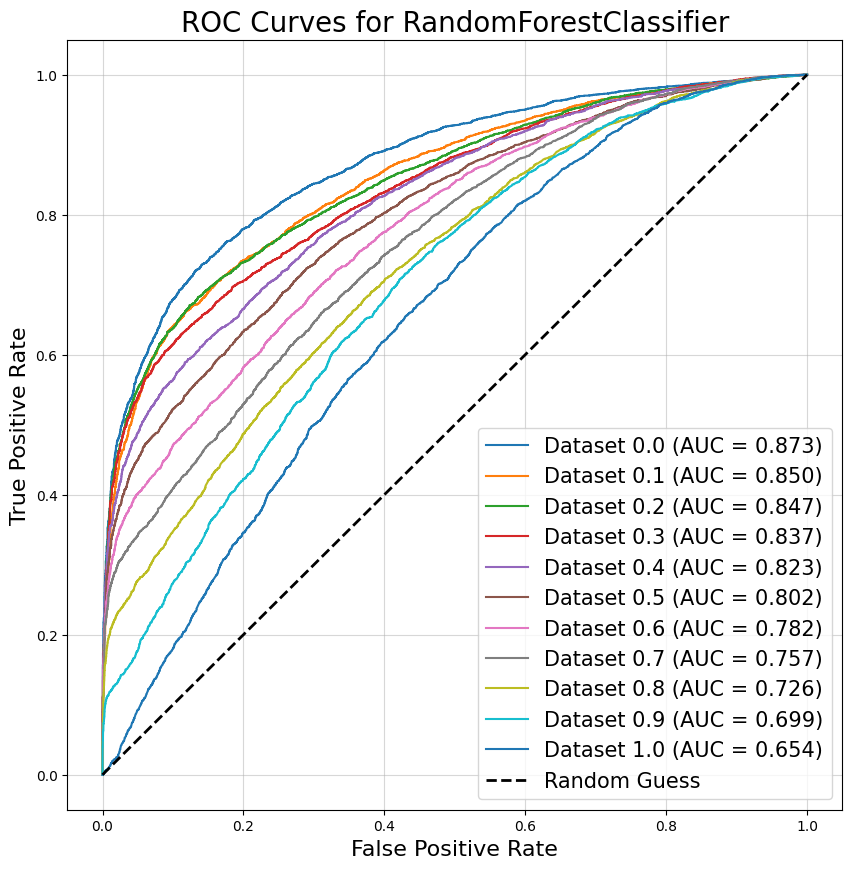

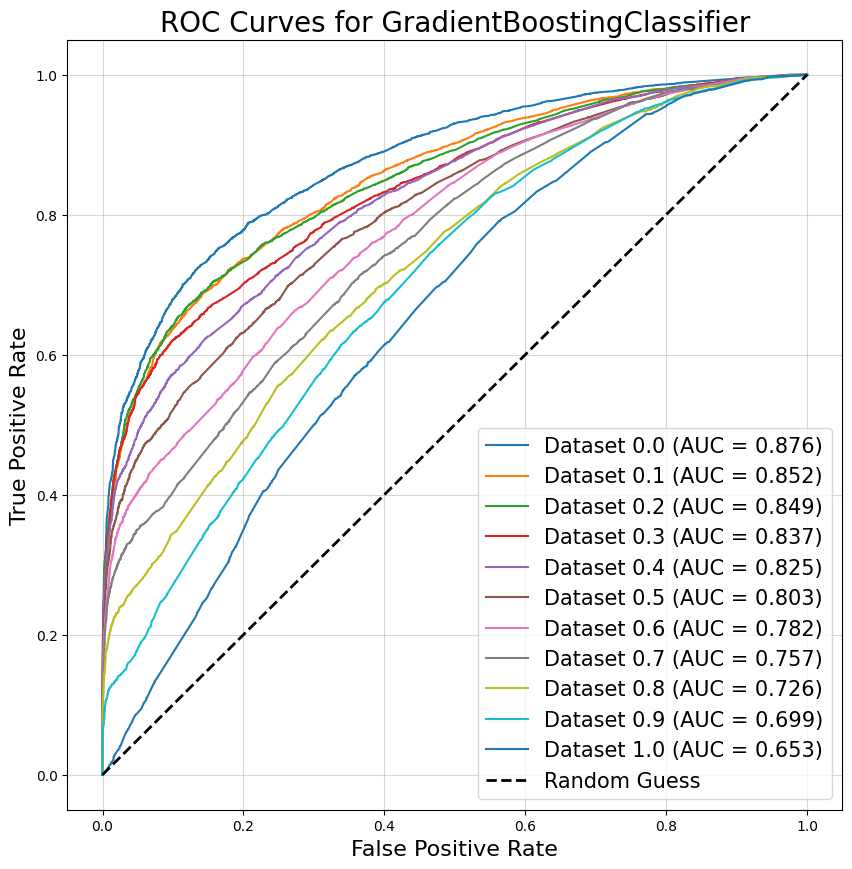

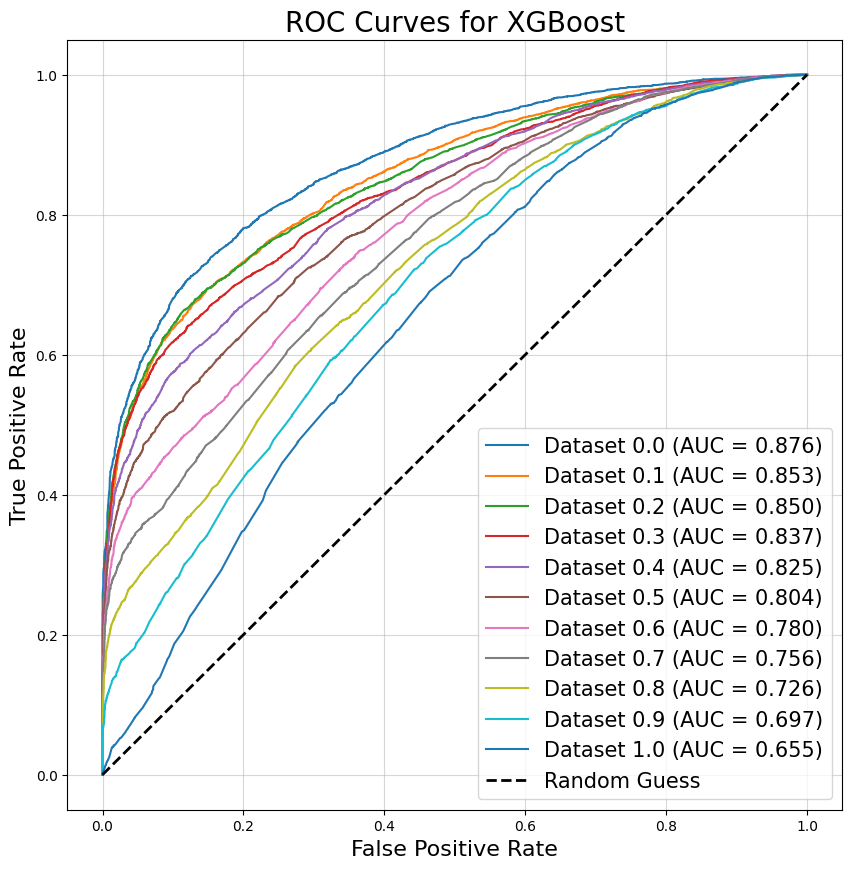

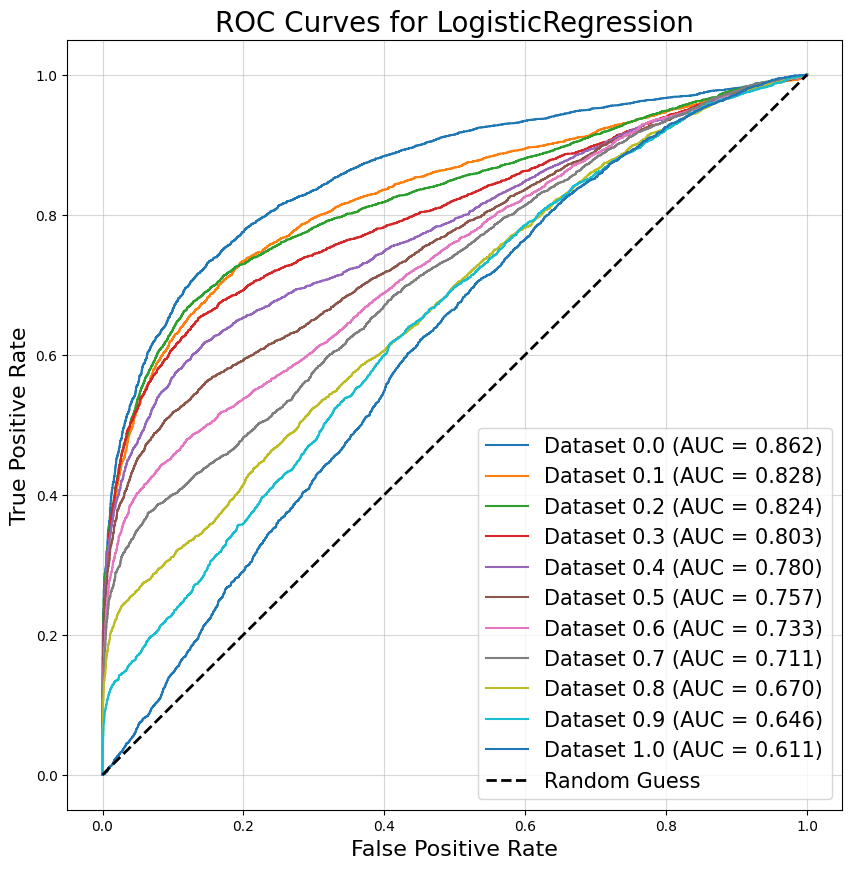

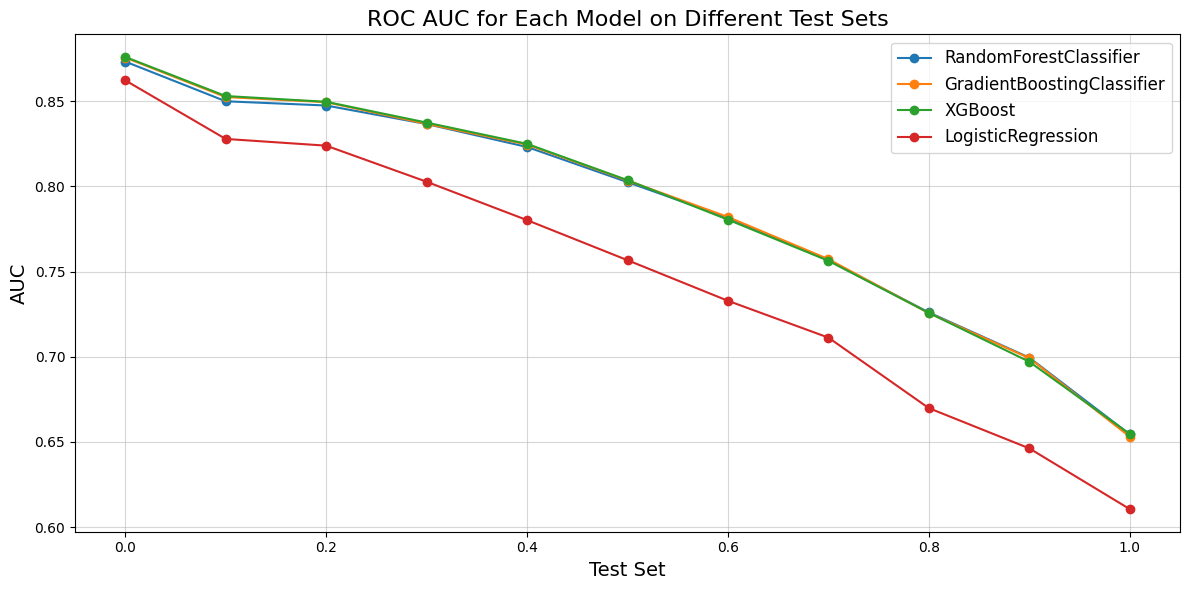

In [25]:
# Define the models to evaluate

models = {
    #"DecisionTreeClassifier"        : dtc_model,
    "RandomForestClassifier"        : rfc_model,
    "GradientBoostingClassifier"    : gbc_model,
    "XGBoost"                       : xgb_model,
    "LogisticRegression"            : lreg_model
}

# Assuming df_dict is a dictionary with keys from 0.1 to 1.0
test_datasets = [(key, df.drop(['Y','Z'], axis=1), df['Y']) for key, df in df_dict.items() if 0.0 <= key <= 1.0]

evaluator = ModelEvaluator(models, test_datasets)
evaluator.evaluate_models(show_metrics = False)
evaluator.plot_roc_curves()
#evaluator.plot_roc_curves_per_dataset()
evaluator.plot_auc()

# 4.0 Statistical Analysis

In [26]:
experiment_df = {}

N_EXP = 50

#if GEN_DATA:
for i in range(N_EXP):
    # shifted random multivariate
    mean_shift = attributes_quantile(df_train, 0.05)

    covariance_shift = random_cov(num_features, -0.5, 0.5)

    # Initialize an empty dictionary to store the dataframes
    experiment_df[i] = {}

    # Iterate over mix_prob values
    for mix_prob in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        # Generate mixture sample
        sample_mix = build_mixture_sample(num_samples, mean_train, covariance_train, mean_shift, covariance_shift, mix_prob=mix_prob)

        # Create a DataFrame for the features
        df_mix = pd.DataFrame(sample_mix, columns=[f'X{i+1}' for i in range(num_features)])

        # Build the target variable y
        y_mix, z_mix, coef_mix = build_poly_target(sample_mix, degree, coefficients=coef_train)
        df_mix['Y'] = y_mix
        df_mix['Z'] = z_mix

        # Store the DataFrame in the dictionary
        experiment_df[i][mix_prob] = df_mix

In [58]:
models = {
    "Gradient Boosting Classifier"    : gbc_model,
    "Random Forest Classifier"        : rfc_model,
    "XGBoost"                         : xgb_model,
    "Logistic Regression"             : lreg_model
    }

results = {}

for idx, test_data in experiment_df.items(): # datasets = {idx : { sh_idx : sh_df }}
    test_datasets = [(key, df.drop(['Y','Z'], axis=1), df['Y']) for key, df in test_data.items() if 0.0 <= key <= 1.0]
    evaluator = ModelEvaluator(models, test_datasets)
    results[idx] = evaluator.evaluate_models(show_metrics=False)

In [57]:
# other_results = {}

# for idx, result in results.items():
#     plt.figure(figsize=(12, 6))
#     for model_name, datasets in result.items():
#         if model_name not in other_results:
#            other_results[model_name] = []
#         dataset_names = [metrics["dataset_name"] for metrics in datasets.values()]
#         auc = [metrics["auc"] for metrics in datasets.values()]
#         plt.plot(dataset_names, auc, marker='o', label=model_name)

#     plt.title("ROC AUC for Each Model on Different Test Sets", fontsize=16)
#     plt.xlabel("Test Set", fontsize=14)
#     plt.ylabel("AUC", fontsize=14)
#     plt.legend(loc="best", fontsize=12)
#     plt.grid(alpha=0.5)
#     plt.tight_layout()
#     plt.show()

In [30]:
final_results = {}

for idx, result in results.items():
    for model_name, datasets in result.items():
        # print(datasets.keys())
        # print()
        if model_name not in final_results:
           final_results[model_name] = []
        #dataset_names = [metrics["dataset_name"] for metrics in datasets.values()]
        auc = datasets[10]["auc"]
        final_results[model_name].append(auc)

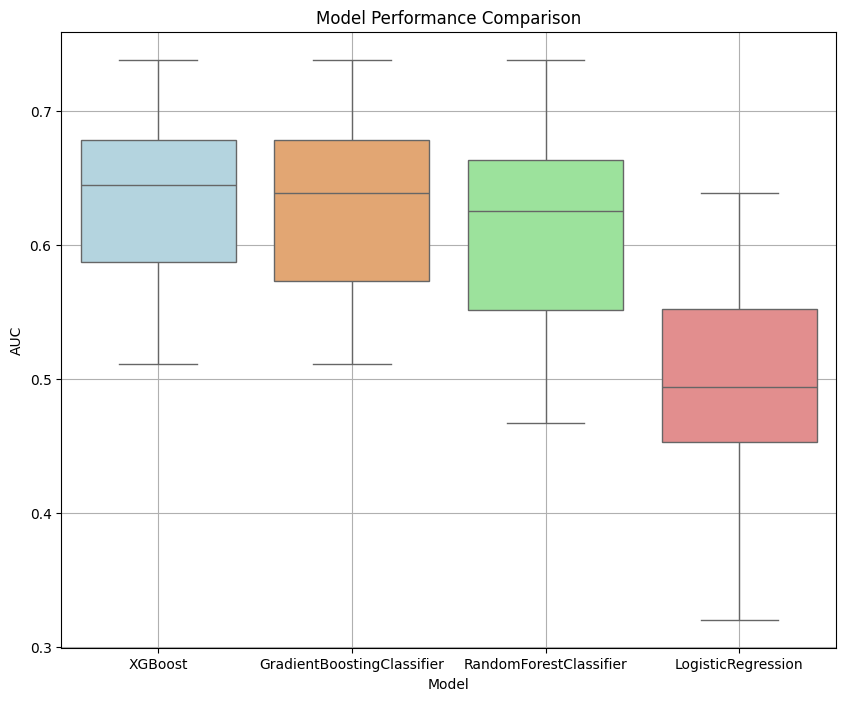

In [55]:
# Convert the final_results dictionary to a DataFrame
results_df = pd.DataFrame(final_results)

# Calculate the median AUC for each model
median_auc = results_df.median().sort_values(ascending=False)

# Sort the DataFrame by the median AUC values
sorted_results_df = results_df[median_auc.index]

# Plot the sorted results
plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=sorted_results_df, palette=['lightblue', 'sandybrown', 'lightgreen', 'lightcoral'])
#ax.set_ylim(0.2, 0.9)
plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('Model Performance Comparison')
plt.grid()
plt.show()

In [ ]:
mean_results = {}

for idx, result in results.items():
    for model_name, datasets in result.items():
        if model_name not in mean_results:
           mean_results[model_name] = []
        # Get AUC values for all datasets (0 to 10)
        #auc_values = 
        # Calculate mean AUC
        mean_auc = np.mean([datasets[i]["auc"] for i in range(11)])
        mean_results[model_name].append(mean_auc)

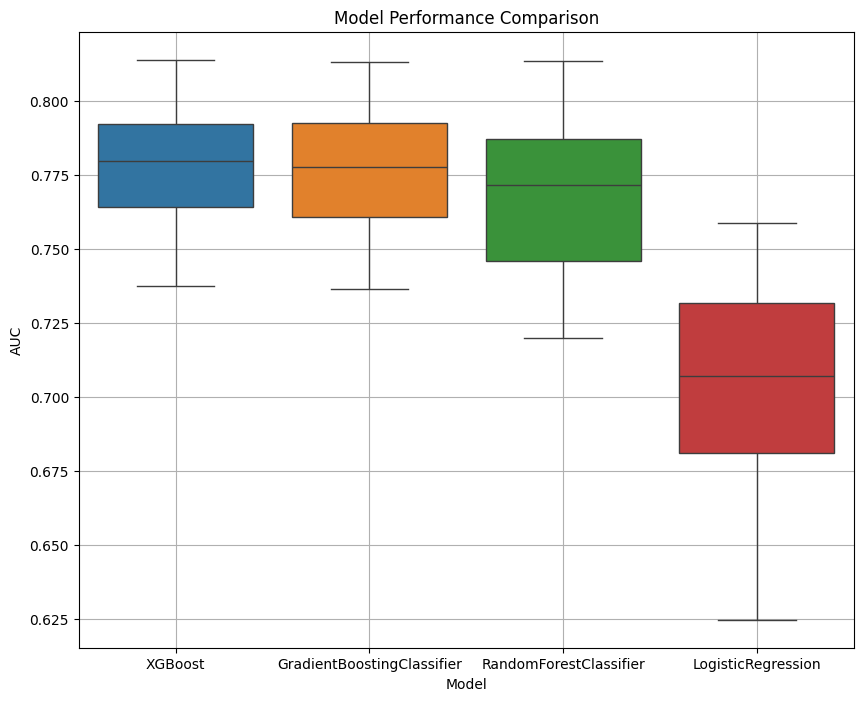

In [40]:
# Convert the final_results dictionary to a DataFrame
results_df = pd.DataFrame(mean_results)

# Calculate the median AUC for each model
median_auc = results_df.median().sort_values(ascending=False)

# Sort the DataFrame by the median AUC values
sorted_results_df = results_df[median_auc.index]

# Plot the sorted results
plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=sorted_results_df)
#ax.set_ylim(0.2, 0.9)
plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('Model Performance Comparison')
plt.grid()
plt.show()